## CREDENTIALS AND SPOTIFY API SETUP

In [54]:
# Credentials for Spotify API
from dotenv import load_dotenv
import os

load_dotenv()  # load environment variables from .env file

conda_env_path = os.getenv("CONDA_ENV_PATH")
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(
    client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## IMPORTING LIBRARIES

In [55]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import time
import random
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
import networkx as nx

## DATA COLLECTION 

In [56]:
# import csv files 
techno_songs = pd.read_csv('datasets/techno_songs.csv')
test_songs = pd.read_csv('datasets/test_songs.csv')
train_songs = pd.read_csv('datasets/train_songs.csv')
all_songs = pd.read_csv('datasets/all_songs.csv')


## DATA OBSERVATION

array([[<AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'key'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>],
       [<AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'valence'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'like'}>]], dtype=object)

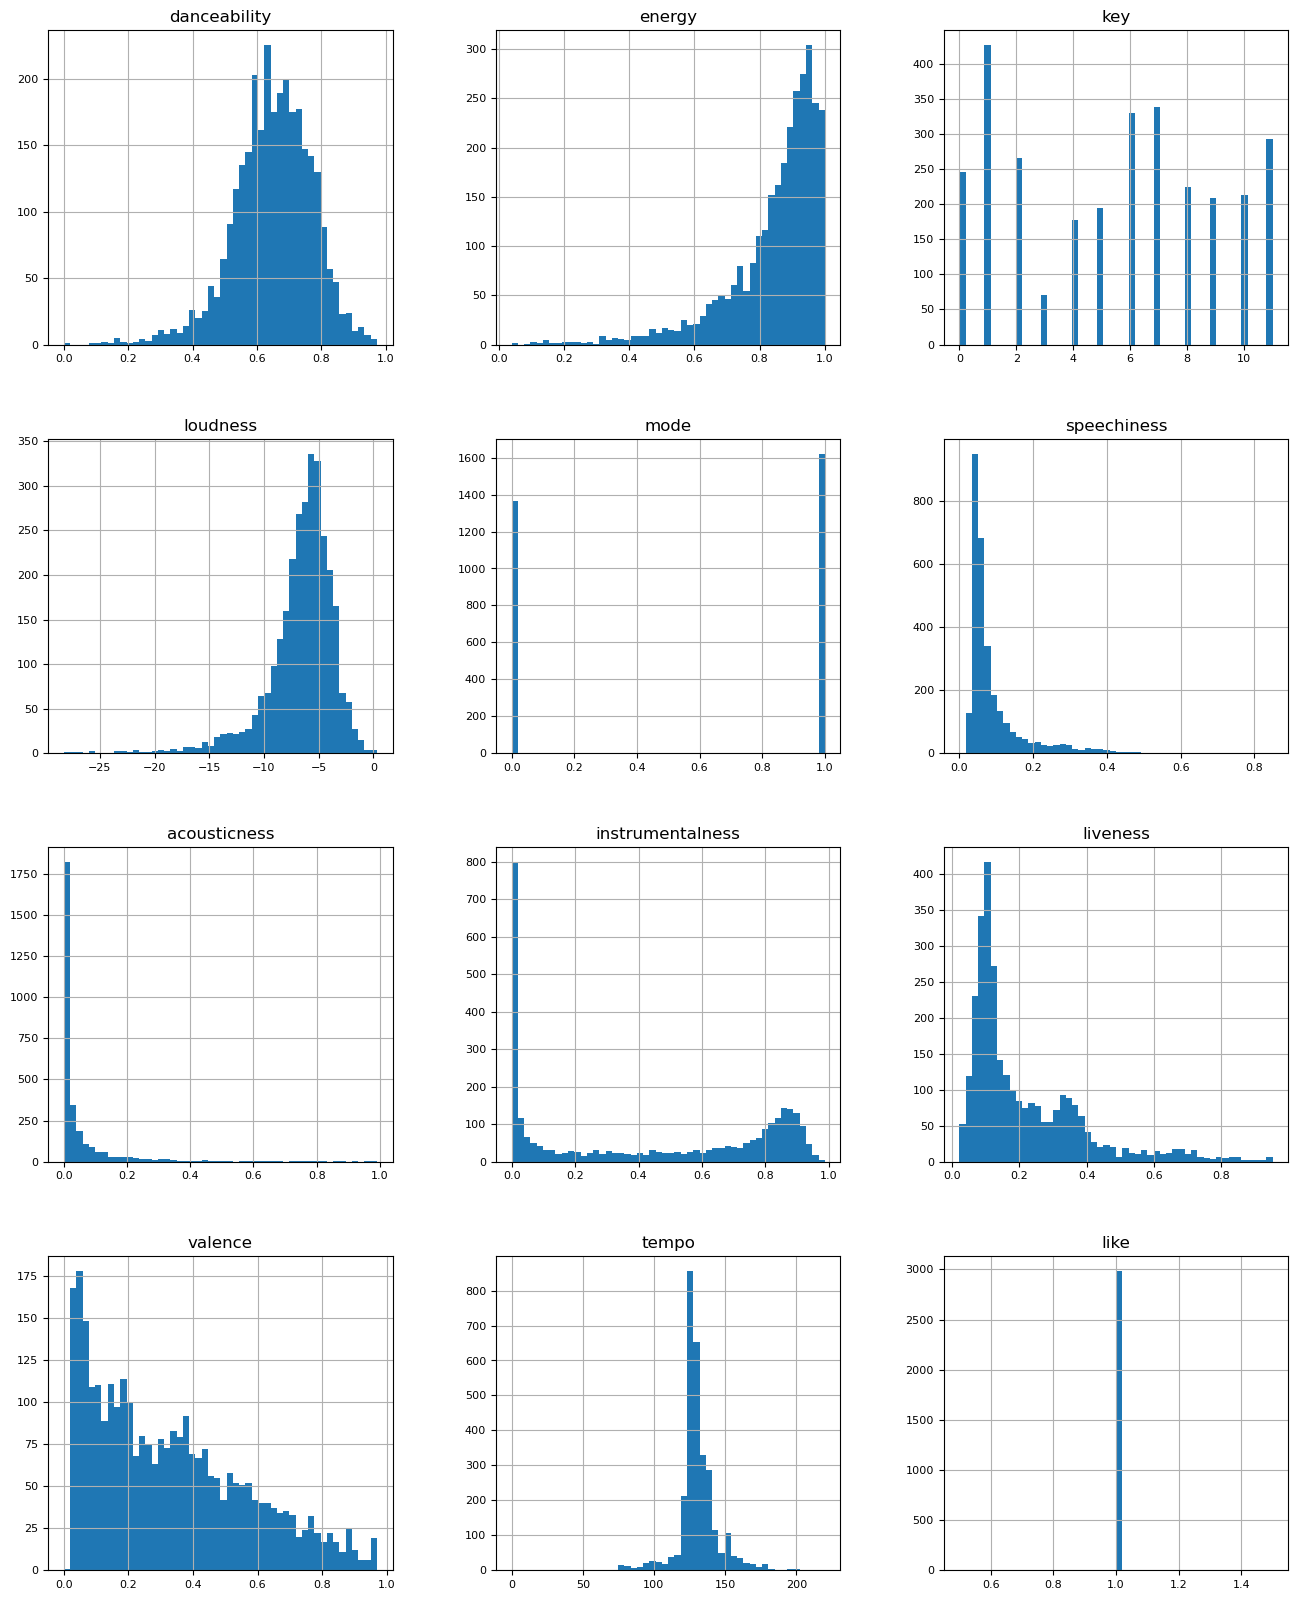

In [57]:
# display the dataframe in a histogram
techno_songs.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)


In [58]:
# print out the count of techno_songs with energy = 1
print('Number of songs with energy = 1:', len(techno_songs[techno_songs['energy'] == 1]))
# print the name of the songs with energy = 1
print('Name of songs with energy = 1:', techno_songs[techno_songs['energy'] == 1]['song_name'].values)

Number of songs with energy = 1: 6
Name of songs with energy = 1: ['Billig' 'Antracita' 'Hooligans' 'Same Type Of Feeling' 'World On Fire'
 'We Just Want Some Boom Boom - Original Mix']


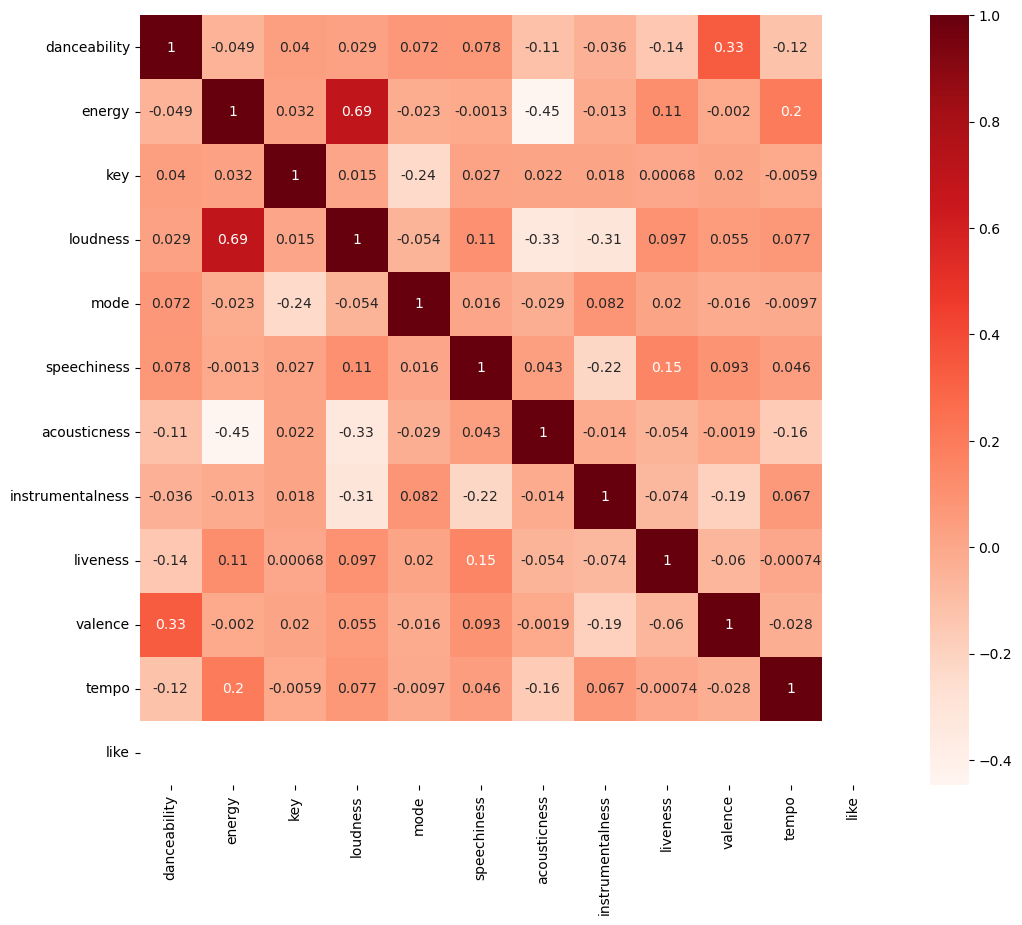

In [59]:
# find the correlation between the features
corr = techno_songs.corr()
corr

# display the correlation in a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()





In [60]:
# based on the techno_songs values, create a new dataframe that has normalized values
techno_songs_norm = techno_songs.copy()
techno_songs_norm[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] = techno_songs_norm[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
techno_songs_norm.describe()
# find the correlation between the normalized features and display in a heatmap
corr_norm = techno_songs_norm.corr()

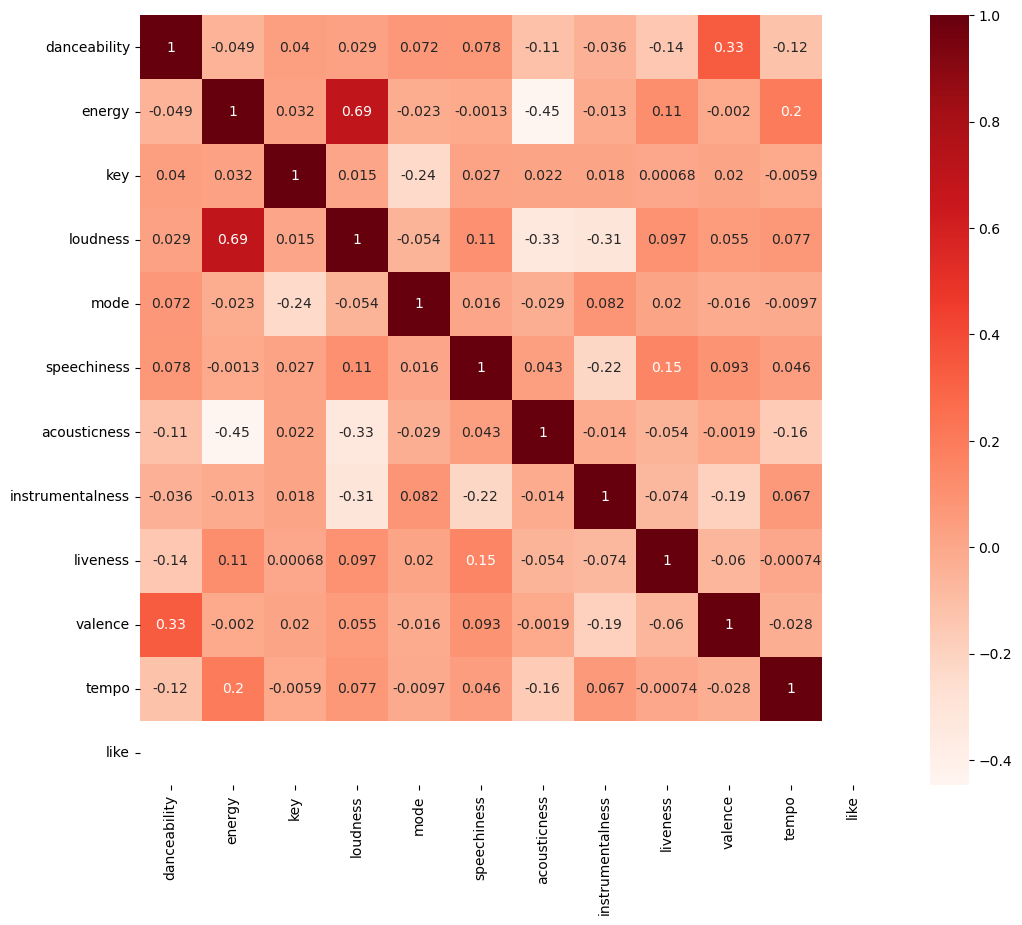

In [61]:
# find the correlation between the normalized features and display in a heatmap
corr_norm = techno_songs_norm.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_norm, annot=True, cmap=plt.cm.Reds)
plt.show()

In [62]:
# remove the upper triangle of the correlation matrix
upper_norm = corr_norm.where(np.triu(np.ones(corr_norm.shape), k=1).astype(np.bool))

# only find the top 4 feature pairs that have the highest correlation
strong_corr_norm = upper_norm.stack().sort_values(ascending=False).iloc[0:4]
strong_corr_norm

C:\Users\USER\AppData\Local\Temp\ipykernel_19872\824417113.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_norm = corr_norm.where(np.triu(np.ones(corr_norm.shape), k=1).astype(np.bool))


energy        loudness    0.689194
danceability  valence     0.332473
energy        tempo       0.197972
speechiness   liveness    0.152288
dtype: float64

In [63]:
# remove the upper triangle of the correlation matrix 
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


# only find the top 4 feature pairs that have the highest correlation
strong_corr = upper.stack().sort_values(ascending=False).iloc[0:4]
strong_corr

C:\Users\USER\AppData\Local\Temp\ipykernel_19872\1889419626.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


energy        loudness    0.689194
danceability  valence     0.332473
energy        tempo       0.197972
speechiness   liveness    0.152288
dtype: float64

In [64]:
# drop the song_name   artist_name                   
techno_songs_norm_num = techno_songs_norm.drop(['song_name', 'artist_name'], axis=1)
techno_songs_norm_num.dtypes

danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
like                  int64
dtype: object

In [66]:
# Function to add neighbors to the graph
def add_neighbors(song_index, depth):
    # Limit the depth to 3
    if depth > 3:
        return
    
    # Get the nearest neighbors of the song
    distances, indices = model_knn.kneighbors(techno_songs_norm_num.iloc[[song_index]])

    # Add an edge for each pair of neighbors
    for j in range(1, len(indices[0])):
        G.add_edge(techno_songs.iloc[song_index]['song_name'], techno_songs.iloc[indices[0][j]]['song_name'])
        
        # Add the neighbors of the neighbor to the graph
        add_neighbors(indices[0][j], depth + 1)

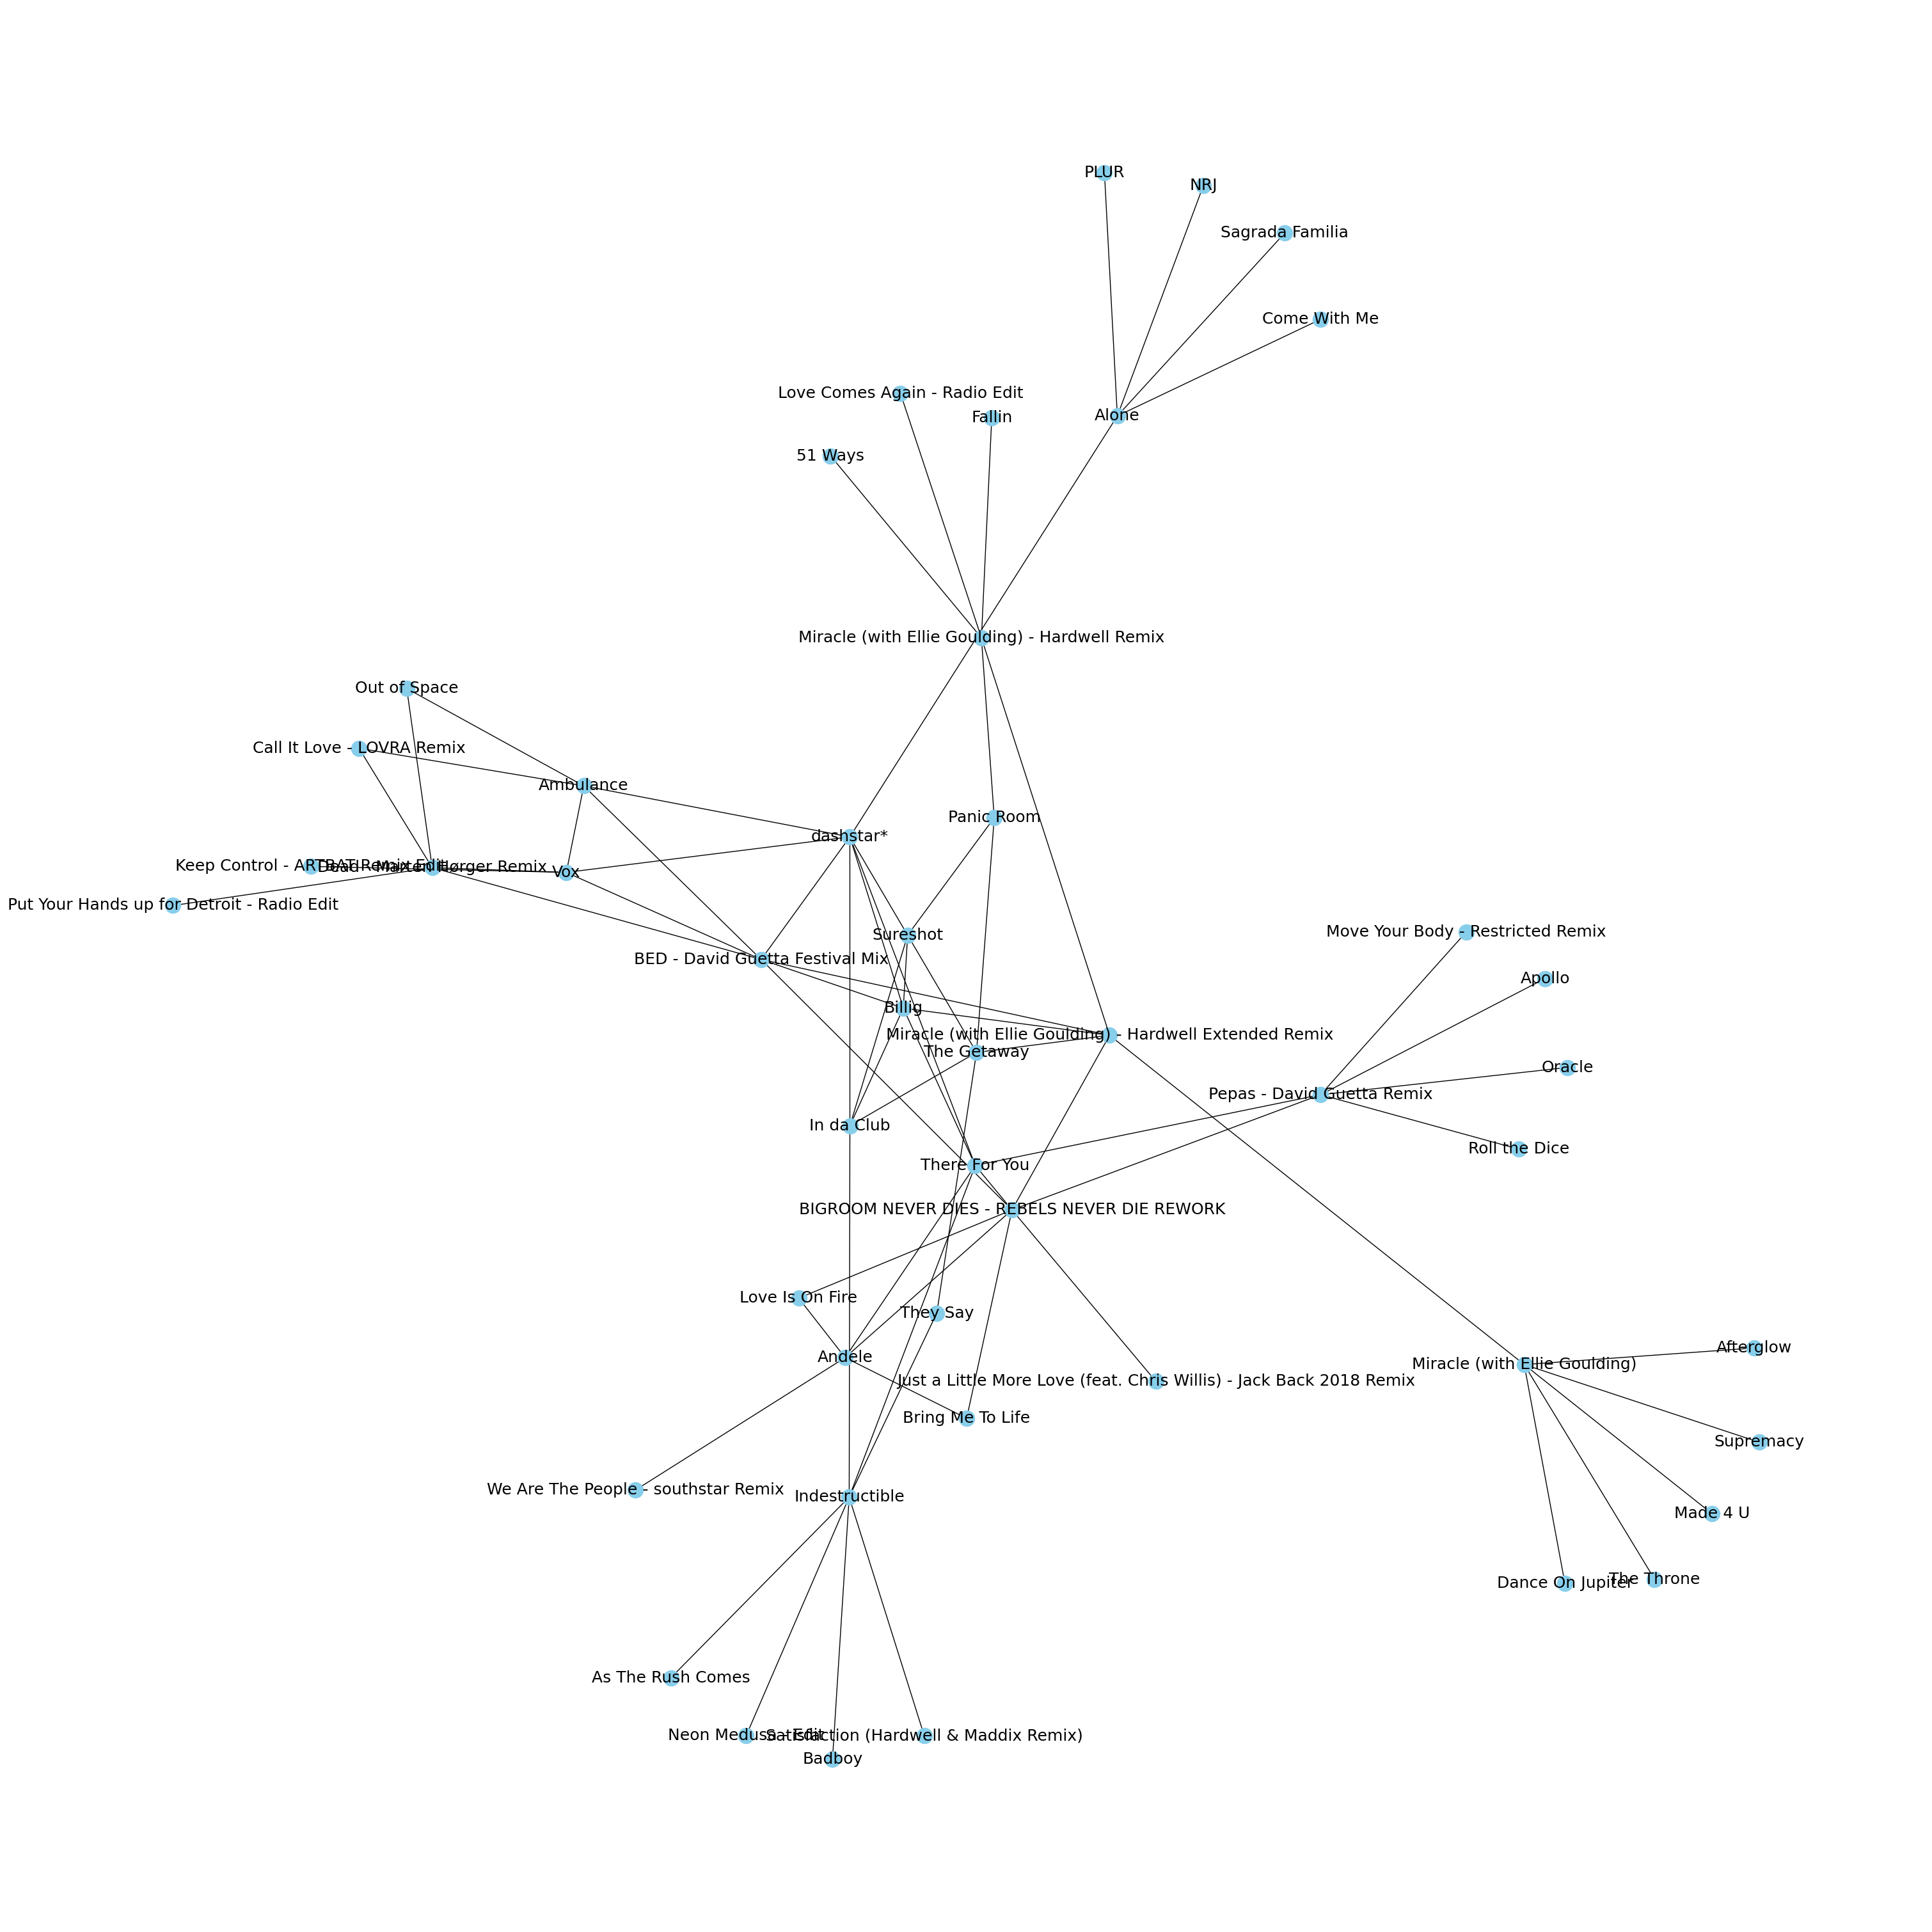

In [67]:
# Let's start with the most 'energetic' song
start_song = techno_songs.nlargest(1, 'energy')

# Get the index of the start song in the normalized dataframe
start_index = start_song.index.tolist()


# Increase figure size
plt.figure(figsize=(30, 30)) # in inches

# Create a graph
G = nx.Graph()

# Add the start song and its neighbors to the graph
add_neighbors(start_index[0], 1)

# Draw the graph
# Increase distance between nodes by adjusting the k parameter in spring_layout
# k is the distance between the nodes and varies between 0 (shortest) and 1 (longest)
pos = nx.spring_layout(G, k=0.2, seed=42)  # Set the seed for reproducibility
# Draw the graph with larger font size and with node color
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_size=18)

# Save the graph to a large image file
# dpi is the resolution
plt.savefig("maps/graph-5.png", format="PNG", dpi=600)


In [68]:
# print the start song 
start_song

,song_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,like
898,Billig,Die Boxenluder,0.838,1.0,10,-5.063,1,0.0904,0.00664,0.282,0.0901,0.216,138.017,1


In [69]:
# split the dataframe from techno_songs into 20% test set and 80% training set
techno_train_songs, techno_test_songs = train_test_split(techno_songs, test_size=0.2)
X_train = pd.concat([techno_train_songs.drop(['song_name', 'artist_name','mode', 'key', 'like'], axis=1), train_songs.drop(['song_name', 'artist_name','mode', 'key', 'like'], axis=1)])
y_train = pd.concat([techno_train_songs['like'], train_songs['like']])
X_test =  pd.concat([techno_test_songs.drop(['song_name', 'artist_name','mode', 'key', 'like'], axis=1), test_songs.drop(['song_name', 'artist_name','mode', 'key', 'like'], axis=1)])
y_test = pd.concat([techno_test_songs['like'], test_songs['like']])
y_train = y_train.astype(int)
y_test = y_test.astype(int)



Text(0.5, 0, 'Number of Neighbors')

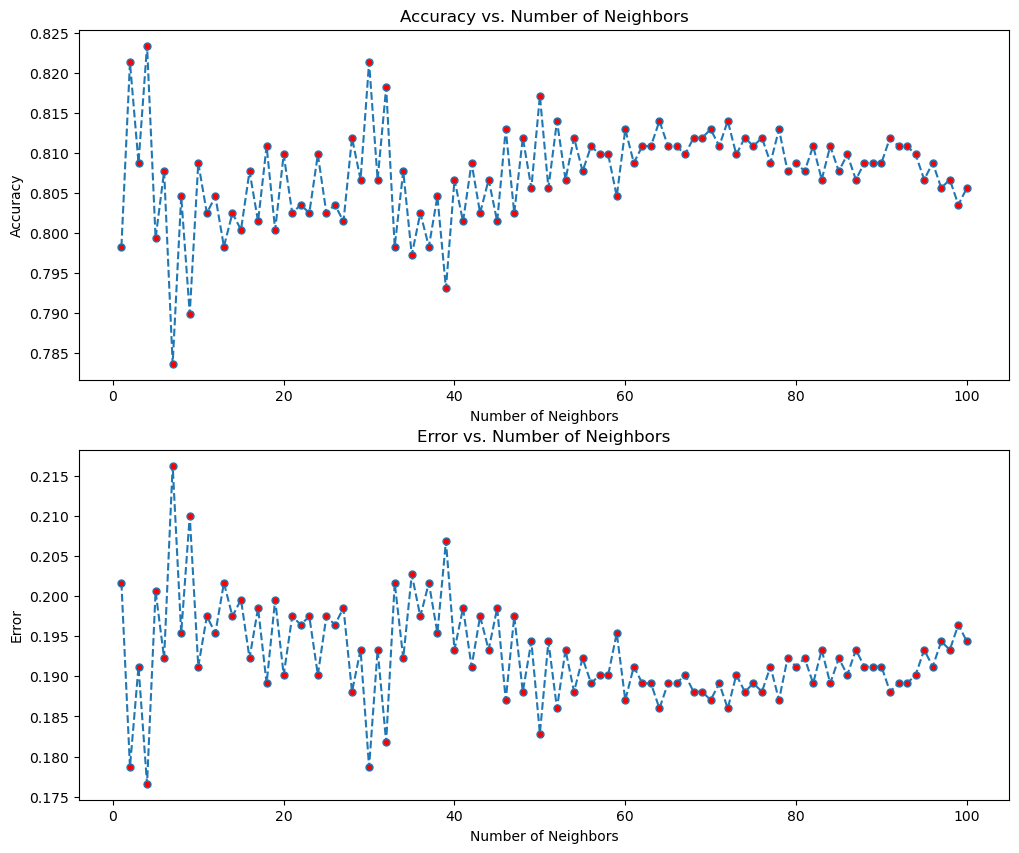

In [70]:
fig, axes = plt.subplots(6, 3, figsize=(12, 10))
neighbors = np.arange(1,101,1)
accuracy = list()
error = list()

for n in neighbors:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)
  accuracy.append(knn.score(X_test, y_test))
  error.append(np.mean(y_test != knn.predict(X_test)))

plt.subplot(2, 1, 1)
plt.plot(neighbors, accuracy, linestyle='dashed', marker='o', markerfacecolor='red', markersize=5)
plt.title('Accuracy vs. Number of Neighbors')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')

plt.subplot(2, 1, 2)
plt.plot(neighbors, error, linestyle='dashed', marker='o', markerfacecolor='red', markersize=5)
plt.title('Error vs. Number of Neighbors')
plt.ylabel('Error')
plt.xlabel('Number of Neighbors')

In [71]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:", knn.score(X_test, y_test))

Accuracy: 0.8098223615464994


In [72]:

# Fetch a number of random songs from Spotify (this is a simplified example, actual implementation may differ)
results = sp.search(q='genre:"Electronic"', limit=20)

# Extract song IDs
song_ids = [track['id'] for track in results['tracks']['items']]

# Get audio features for these songs
audio_features = sp.audio_features(song_ids)

# Create a DataFrame from the audio features
songs_df = pd.DataFrame(audio_features)

# Drop unnecessary columns from the DataFrame
songs_df = songs_df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'mode', 'key','duration_ms','time_signature'], axis=1)

# Use the KNN model to predict whether you'll like the songs
predictions = knn.predict(songs_df)

# Create a DataFrame of the songs and predictions
songs_and_predictions = pd.DataFrame({
    'prediction': predictions,
    'song_id': song_ids,
    'song_name': [next((item['name'] for item in results['tracks']['items'] if item['id'] == song_id), '') for song_id in song_ids],
    'artist_name': [next((item['artists'][0]['name'] for item in results['tracks']['items'] if item['id'] == song_id), '') for song_id in song_ids]
})


# Print the DataFrame
songs_and_predictions

,prediction,song_id,song_name,artist_name
0,1,0ITaSRuI0L1RNL7ZNYTTi7,U Are My High (with Future),DJ Snake
1,0,0lYBSQXN6rCTvUZvg9S0lU,Let Me Love You,DJ Snake
2,0,0g5EKLgdKvNlln7TNqBByK,Middle,DJ Snake
3,0,57kR5SniQIbsbVoIjjOUDa,You Know You Like It,DJ Snake
4,0,2oDqmfa2g8W893LlwJG1qu,Closer,Nine Inch Nails
5,0,4LIM4qmpHABufePRrLWbiM,QKThr,Aphex Twin
6,0,2qLSXZuIHMsKydCEFDchc3,Bang Bang Bang Bang,Sohodolls
7,0,4w8niZpiMy6qz1mntFA5uM,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",DJ Snake
8,1,3OaunNUlXXs5e2PXtNAzzG,UCLA,RL Grime
9,0,67awxiNHNyjMXhVgsHuIrs,Turn Down for What,DJ Snake
